In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 6.3 Identifying a stationary ARMA process 

If your process is stationary and both the ACF and PACF plots show a decaying or sinusoidal pattern, then it is a stationary ARMA(p,q) process

Let's simulate our own ARMA process

In [2]:
# Pg 108

np.random.seed(42)

ar1 = np.array([1, -0.33])  # Coefficient with opposite sign than in equation
ma1 = np.array([1, 0.9])    # Coefficient with same sign than in equation

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [3]:
# Pg 108

ADF_result = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# It shows stationarity

ADF Statistic: -6.42987868204269
p-value: 1.7078466680096923e-08


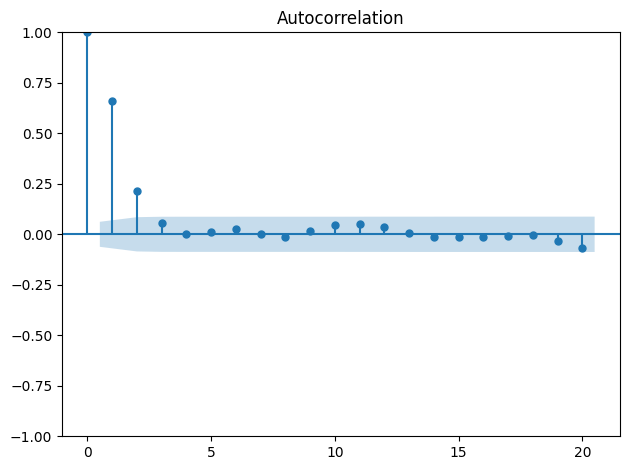

In [4]:
# Figure 6.4 in pg 109

plot_acf(ARMA_1_1, lags=20)

plt.tight_layout()

plt.savefig('figures/CH06_F05_peixeiro.png', dpi=300)

Notice the sinusoidal pattern, which indicates the presence of an autoregressive process

ACF plot does not revel any useful information about the order q of any process we would consider to use

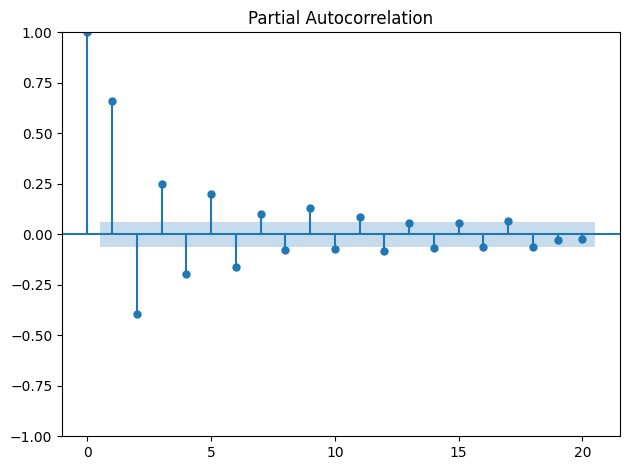

In [5]:
# Figure 6.5 in pg 110

plot_pacf(ARMA_1_1, lags=20)

plt.tight_layout()

plt.savefig('figures/CH06_F06_peixeiro.png', dpi=300)

Notice the sinusoidal pattern, we cannot infer a value for the order p.
PACF plot does not revel any useful information about the order q of any process we would consider to use

## 6.4 Devising a general modeling procedure

### 6.4.1 Selecting the best model 

### 6.4.2 Selecting a model using the AIC (Akaike Information Criterion)
Relative quality to other models

In [6]:
# Pg 114

ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [7]:
# Pg 115

from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [8]:
# Pg 115
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df
# Outputs Figure 6.7 in pg 116

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(2, 3)",2806.175380
8,"(3, 3)",2806.237460
9,"(3, 2)",2806.894930


### 6.4.3 Understanding residuals analysis 

Absolute measure of model's quality

#### Qualitative analysis: studying the Q-Q plot

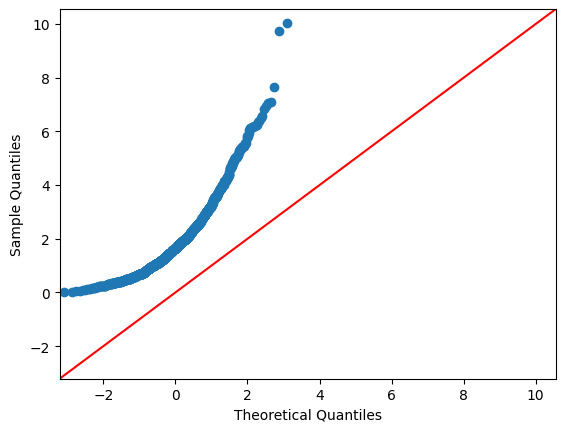

In [9]:
# Figure 6.10 in pg 119

from statsmodels.graphics.gofplots import qqplot

gamma = np.random.default_rng().standard_gamma(shape=2, size=1000)

qqplot(gamma, line='45');

plt.savefig('figures/CH06_F11_peixeiro.png', dpi=300)

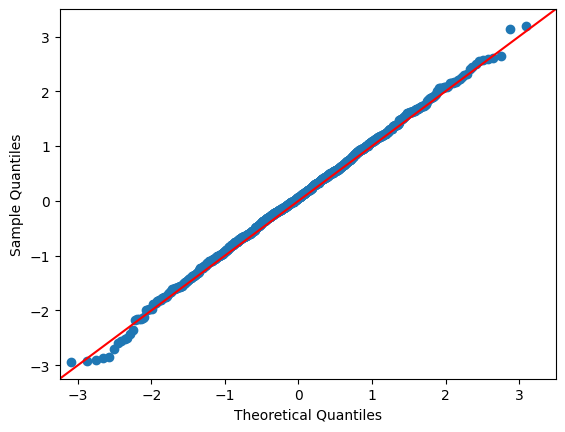

In [10]:
# Figure 6.9 in pg 119

normal = np.random.normal(size=1000)

qqplot(normal, line='45');

plt.savefig('figures/CH06_F10_peixeiro.png', dpi=300)

### 6.4.4 Performing residuals analysis 

In [11]:
# Pg 121

model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

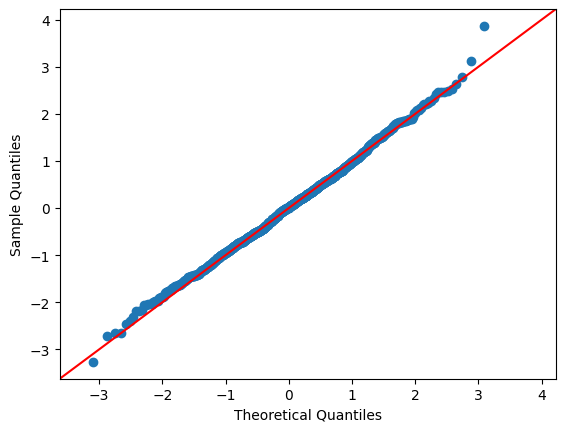

In [12]:
# Figure 6.12 in pg 123

from statsmodels.graphics.gofplots import qqplot

qqplot(residuals, line='45');

plt.savefig('figures/CH06_F13_peixeiro.png', dpi=300)

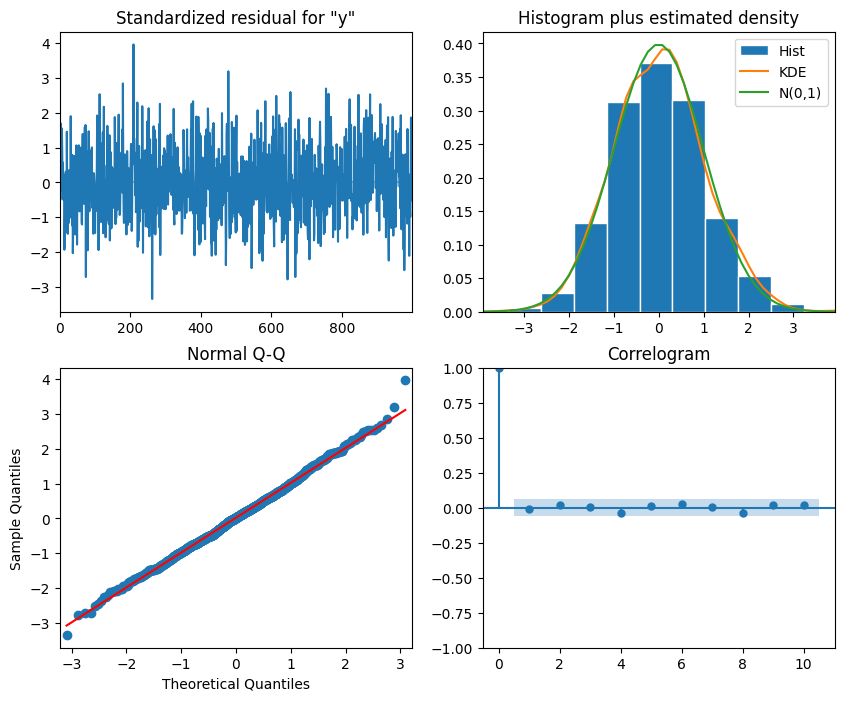

In [13]:
# Figure 6.13 in pg 124

model_fit.plot_diagnostics(figsize=(10, 8))

plt.savefig('figures/CH06_F14_peixeiro.png', dpi=300)

In [14]:
# Pg 124

# CODE DEPRECATED

# from statsmodels.stats.diagnostic import acorr_ljungbox

# lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# print(pvalue)

In [15]:
# Pg 124

from statsmodels.stats.diagnostic import acorr_ljungbox

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,0.030706,0.860897
2,0.528021,0.767966
3,0.540904,0.909817
4,2.079774,0.721089
5,2.271897,0.810385
6,2.896262,0.821750
7,2.900378,0.894063
8,4.418799,0.817501
9,4.787567,0.852419
10,5.246805,0.874093


## 6.5 Applying the general modeling procedure 

In [16]:
# Pg 126

import pandas as pd

df = pd.read_csv('../data/bandwidth.csv')

df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


In [17]:
df.shape

(10000, 1)

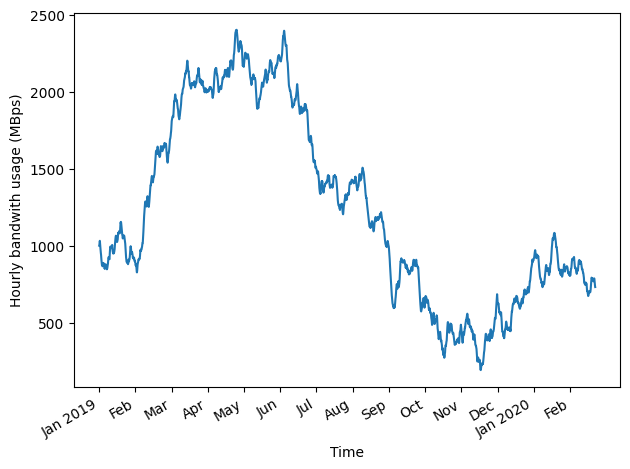

In [18]:
# Figure 6.15 in pg 126
# Figure 6.1 in pg 103

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH06_F02_peixeiro.png', dpi=300)

In [19]:
# Pg 127

ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# It shows non-stationarity

ADF Statistic: -0.8714653199452511
p-value: 0.7972240255014622


In [20]:
# Pg 127
bandwidth_diff = np.diff(df['hourly_bandwidth'], n=1)

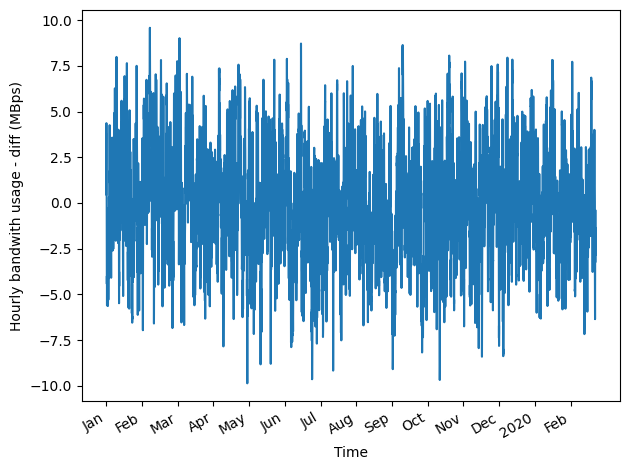

In [21]:
# Figure not in the book

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(bandwidth_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage - diff (MBps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH06_F_peixeiro.png', dpi=300)

In [22]:
# Pg 127
ADF_result = adfuller(bandwidth_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# It shows stationarity

ADF Statistic: -20.69485386378902
p-value: 0.0


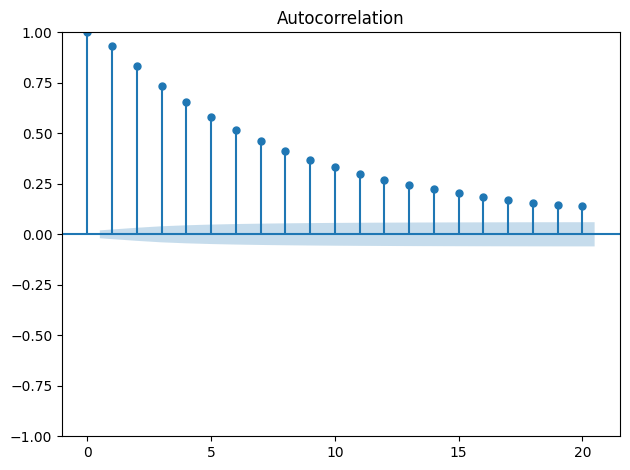

In [23]:
# Figure not in the book
plot_acf(bandwidth_diff, lags=20)

plt.tight_layout()

# plt.savefig('figures/CH06_F_peixeiro.png', dpi=300)

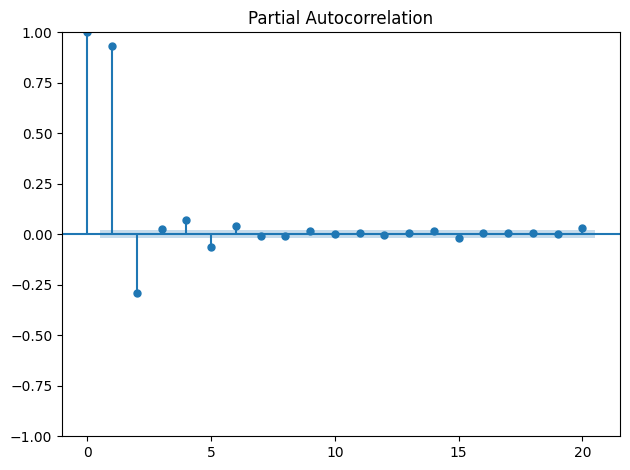

In [24]:
# Figure not in the book
plot_pacf(bandwidth_diff, lags=20)

plt.tight_layout()

# plt.savefig('figures/CH06_F_peixeiro.png', dpi=300)

In [25]:
# Pg 127
# Forecast last week = 168 hours
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

9831
168


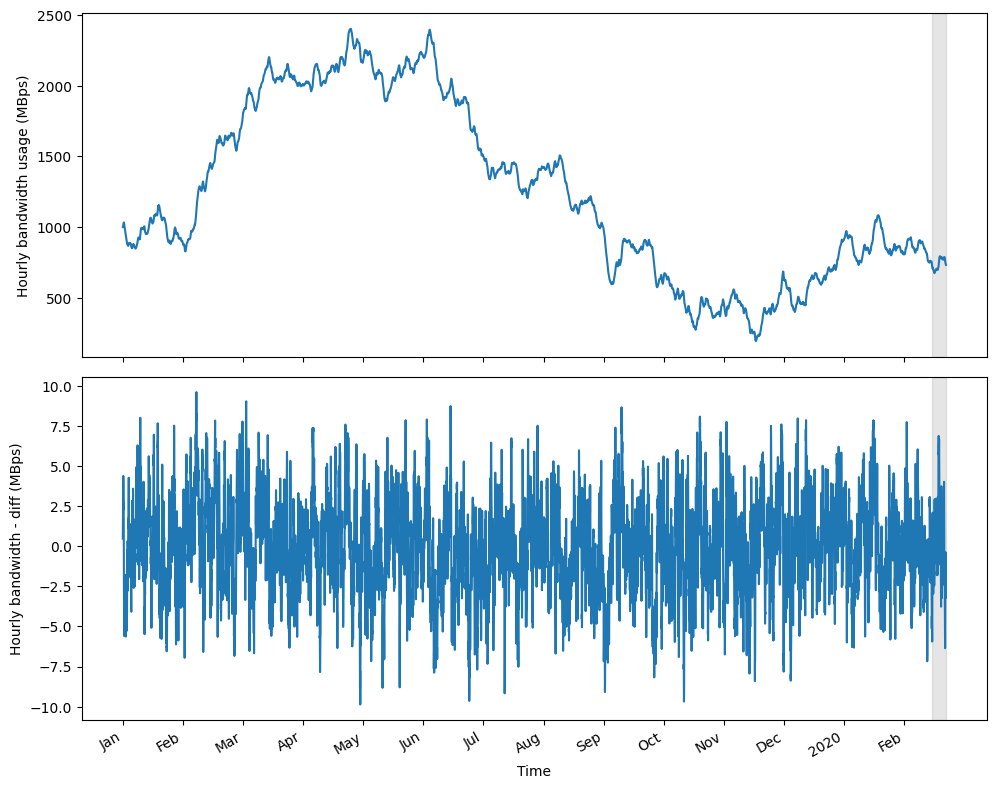

In [26]:
# Figure 6.16 in pg 126

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth usage (MBps)')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax2.plot(df_diff['bandwidth_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth - diff (MBps)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH06_F17_peixeiro.png', dpi=300)

In [27]:
# Pg 129. Same as in pg 115
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [28]:
# Pg 130

ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [29]:
# Pg 130
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df
# Outputs Figure 6.17 in pg 130

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


In [30]:
# Pg 131
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

# StackOverflow to save output as png
# Output not shown in the book

                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13990.802
Date:                Mon, 09 Feb 2026   AIC                          27991.604
Time:                        16:51:23   BIC                          28027.570
Sample:                             0   HQIC                         28003.788
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

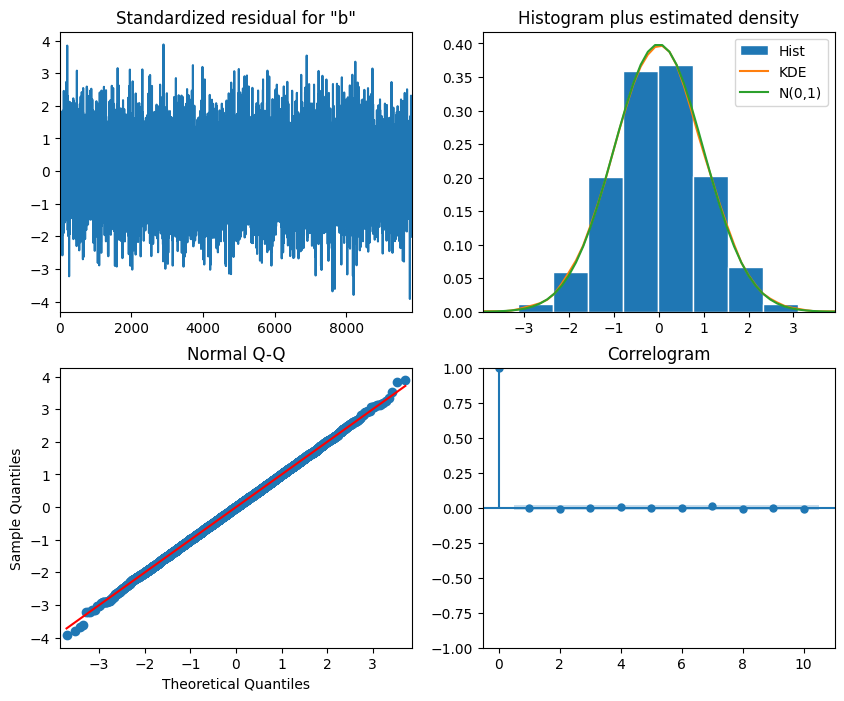

In [31]:
# Figure 6.18 in pg 131

model_fit.plot_diagnostics(figsize=(10, 8))

plt.savefig('figures/CH06_F19_peixeiro.png', dpi=300)

The top-left plot shows no trend, and the mean seems constant over time, meaning that our residuals are likely stationary. Let's check it with Augmented Dickey Fuller (ADF)

In [32]:
residuals = model_fit.resid

ADF_result = adfuller(residuals)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
# It shows stationarity

ADF Statistic: -99.3393354678007
p-value: 0.0


In [33]:
# CODE DEPRECATED
# Pg 132

#residuals = model_fit.resid

# lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# print(pvalue)
# print(lbvalue)

In [34]:
# Pg 132

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

# The returned p-values all exceed 0.05. We conclude our residuals are uncorrelated

,lb_stat,lb_pvalue
1,0.042190,0.837257
2,0.418364,0.811247
3,0.520271,0.914416
4,0.850555,0.931545
5,0.850841,0.973678
6,1.111754,0.981019
7,2.124864,0.952607
8,3.230558,0.919067
9,3.248662,0.953615
10,3.588289,0.964015


Our ARMA(2,2) has passed all the checks on the residual analysis, and we are ready to use this model too forecast bandwidth usage

## 6.6 Forecasting bandwidth usage

In [35]:
# Pg 132

def rolling_forecast(df: pd.Series, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1]#.values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [36]:
# Pg 133

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff['bandwidth_diff'], TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff['bandwidth_diff'], TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff['bandwidth_diff'], TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

,bandwidth_diff,pred_mean,pred_last_value,pred_ARMA
9831,-5.943995,-0.028214,-5.791207,-5.460661
9832,-5.865194,-0.028816,-5.943995,-5.478227
9833,-3.197066,-0.029410,-5.865194,-5.335905
9834,-1.090197,-0.029732,-3.197066,-2.151610
9835,0.665291,-0.029840,-1.090197,-0.375596


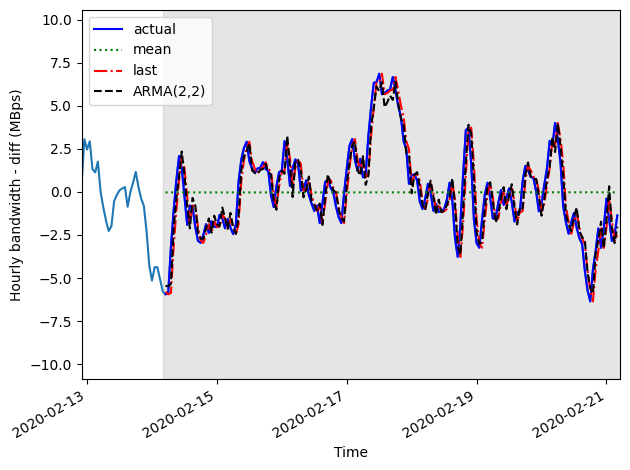

In [37]:
# Figure 6.19 in pg 134

fig, ax = plt.subplots()

ax.plot(df_diff['bandwidth_diff'])
ax.plot(test['bandwidth_diff'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (MBps)')

ax.axvspan(9830, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH06_F20_peixeiro.png', dpi=300)

In [38]:
# Pg 135

mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

6.30595040487273 1.1794626564346626 0.9004296731596697


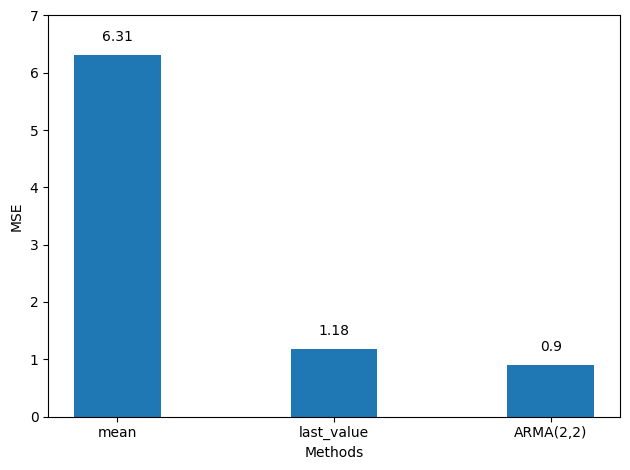

In [39]:
# Figure not in the book

fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARMA(2,2)']
y = [mse_mean, mse_last, mse_ARMA] 

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 7)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

# plt.savefig('figures/CH06_F_peixeiro.png', dpi=300)

*****************************************************************

Inverting transformation (differencing)

Instead of:

In [40]:
# # Pg 135, reversing the transformation

# df['pred_bandwidth'] = pd.Series()
# df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()

Let's do:

In [41]:
df['hourly_bandwidth'][9831:].head()  # shape (10000,)

9831    723.120934
9832    717.176939
9833    711.311745
9834    708.114679
9835    707.024482
Name: hourly_bandwidth, dtype: float64

In [42]:
test['pred_ARMA'].head()  # shape (50,)

9831   -5.460661
9832   -5.478227
9833   -5.335905
9834   -2.151610
9835   -0.375596
Name: pred_ARMA, dtype: float64

In [43]:
zz=df['hourly_bandwidth'][9831:]+test['pred_ARMA']
zz.head()

9831    717.660272
9832    711.698712
9833    705.975840
9834    705.963069
9835    706.648886
dtype: float64

In [44]:
zzz=zz.shift(periods=1).dropna()
zzz.head()

9832    717.660272
9833    711.698712
9834    705.975840
9835    705.963069
9836    706.648886
dtype: float64

In [45]:
zzz.tail()

9995    739.266330
9996    740.871410
9997    736.808125
9998    733.082145
9999    731.543968
dtype: float64

In [46]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = zzz

*****************************************************************

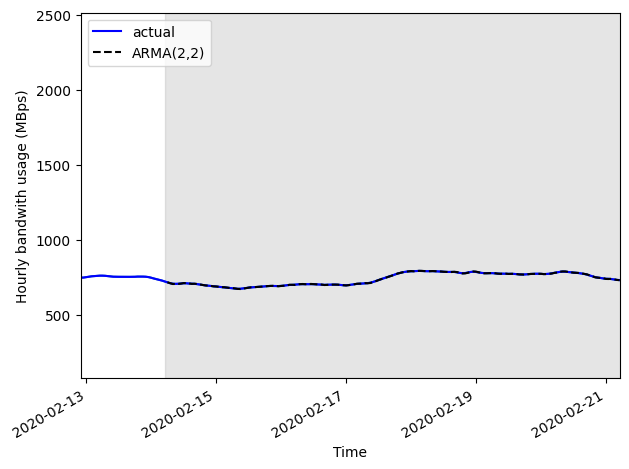

In [47]:
# Figure 6.20 in pg 136

fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

ax.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH06_F21_peixeiro.png', dpi=300)

In [48]:
# Pg 136

mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])

print(mae_ARMA_undiff)

0.7839482268041619


CH06.ipynb: On average, our predictions are 14Mbps above or below the actual bandwidth usage

CH06_cumsum_error.ipynb: On average, our predictions are 0.8 Mbps above or below the actual bandwidth usage

CH07_exercise_7.5.1_6_2.1.2.ipynb: On average, our predictions are 0.8 Mbps above or below the actual bandwidth usage